In [3]:
### imports ###
import pygmt
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.image as mpimg 
from mpl_toolkits.basemap import Basemap

import pandas as pd

%matplotlib inline
%matplotlib widget

In [ ]:
# Major tectonic blocks and faults are marked by black lines (after Styron et al. (2010) and Taylor and An Yin (2009))
# https://github.com/HimaTibetMap/HimaTibetMap/tree/master
# Styron, R., Taylor, M., and Okoronkwo, K., 2010, HimaTibetMap-1.0: new ‘web-2.0’ online database of active structures from the Indo-Asian collision, Eos, vol.91 no. 20.
# Taylor, Michael, and An Yin, 2009, "Active structures of the Himalayan-Tibetan orogen and their relationships to earthquake distribution, contemporary strain field, and Cenozoic volcanism." Geosphere vol. 5, no. 3, pp 199-214.
# gem_active_faults.gmt https://github.com/GEMScienceTools/gem-global-active-faults
# Slab contours are from the slab model of Hayes et al. (2018).
# Hayes, G., 2018, Slab2 - A Comprehensive Subduction Zone Geometry Model: U.S. Geological Survey data release, https://doi.org/10.5066/F7PV6JNV. 

# Seismicity from the Harvard CMT cffatalogue (Dziewonski et al. (1981), Ekstr ̈om et al. (2012), https://www.globalcmt.org/.
# InSAR DURATION ONLY 20160309 20240710


In [4]:
def gmt_png_test(png_path, region, projection, xshift, yshift):
    '''
    Creates an interactive map from a borderless pyGMT png where you can click to retrieve coordinates.

    Parameters:
        png_path (str): path to the borderless PyGMT map
        region (str/ list): pygmt region input
        projection (str): pygmt map projection input
        xshift: xshift left from bottom left corner relative to background canvas
        yshift: yshift upwards from bottom-most basemap extent relative to background canvas

    Example (see demo_conical/cascadia.ipynb):

        region=[-136, -118.5, 38.5, 53.1]
        projection="B-127.25/45.8/43.19/47.86/11c"

        %matplotlib widget
        gmt_png("cascadia.png", region, projection, "2c", "5c")

    '''

    ########## inputs ##########
    # turn pygmt region input into gmt str
    if isinstance(region, str):
      region_str = region
    elif isinstance(region, list):
      region_str = f"{region[0]}/{region[1]}/{region[2]}/{region[3]}"
    else:
      raise Exception("invalid region input (must be either a str or a list)") 


    # unpact xshift yshift
    def unpack_xyshift(str):
      if str[-1].isalpha():
        shift_value = str[:-1]
        shift_unit = str[-1]

      else: 
        raise Exception("invalid xshift or yshift input") 
      
      return float(shift_value), shift_unit


    xshift_value, xshift_unit = unpack_xyshift(xshift)
    yshift_value, yshift_unit = unpack_xyshift(yshift)

    # we are working in cm
    if xshift_unit == "c":
      xshift_value = xshift_value
    elif xshift_unit == "i":
      xshift_value = xshift_value * 2.54
    elif xshift_unit == "p":
      xshift_value = (xshift_value * 72) * 2.54
    else:
      raise Exception("invalid xshift input (must be either c, i or p)") 
      
    # similarly for y
    if yshift_unit == "c":
      yshift_value = yshift_value
    elif yshift_unit == "i":
      yshift_value = yshift_value * 2.54
    elif yshift_unit == "p":
      yshift_value = (yshift_value * 72) * 2.54
    else:
      raise Exception("invalid yshift input (must be either c, i or p)") 
    

    # determine image dimension
    img = Image.open(png_path)
    width, height = img.size # canvas (width,height) tuple in pixels
    DPI_horz, DPI_vert = img.info.get('dpi')

    assert DPI_horz == DPI_vert # is this != even possible??


    ################################################
    ########## plots ##########
    fig = plt.figure(figsize=(width/DPI_horz, height/DPI_vert))
    ax1 = plt.subplot(111)

    '''
    code above doesnt "work' in the sense that its unnecessary
    as figure size != subplot axis size --> what to do with multiple subplots eg timeseries
    edit: subplot axis is currently set to image pixel size so ok now
    '''

    # plotting pygmt png image in bottom layer
    img = mpimg.imread(png_path)

    plt.imshow(img, origin='upper')
    # SOMEHOW MATPLOTLIB MIRRORS MY IMAGE WHEN I SET (0,0) AS BOTTOM LEFT (origin='lower')
    # i fix this later directly at pos_to_lonlat (by reversing input)

    
    def pos_to_lonlat(x, y):
      # xyshift input in cm
      x=(x/DPI_horz) * 2.54 # convert pixel to cm
      x = x - xshift_value

      y=(y/DPI_vert) * 2.54 # cm
      height_cm = (height/DPI_vert) * 2.54
      y = height_cm - y - yshift_value
      
      x=[x] # must be list with one value or np array
      y=[y]
      
      ### lon lat conversion using mapproject ###
      with Session() as ses:
        with ses.virtualfile_from_vectors(x, y) as fin:
          args = [f'{fin}', f'-R{region_str}', f'-J{projection}', '-I']
          with GMTTempFile() as fout:
            ses.call_module(module="mapproject", args=' '.join(args)+ " ->" + fout.name)
            out = fout.read().strip()

      lon, lat = [float(i) for i in out.split(' ')]
    
      return lon, lat


    pos = [] # in format [[None, None], [x, y], [x, y], ...]
    lonlat = []

    def onclick(event):
      pos.append([event.xdata, event.ydata])

      lon, lat = pos_to_lonlat(float(pos[-1][0]), float(pos[-1][1]))
      # converts x y to lon lat and appends
      # pos[-1] represents last click (list with x, y)
      # this is x y input in pixels --> need to convert to cm (gmt input)
      lonlat.append([lon, lat])

      ax1.set_title(f'Click {len(pos)}: {lon}, {lat}')

    
    cid=fig.canvas.mpl_connect('button_press_event', onclick)

    plt.axis('off')
    plt.show()

    return 


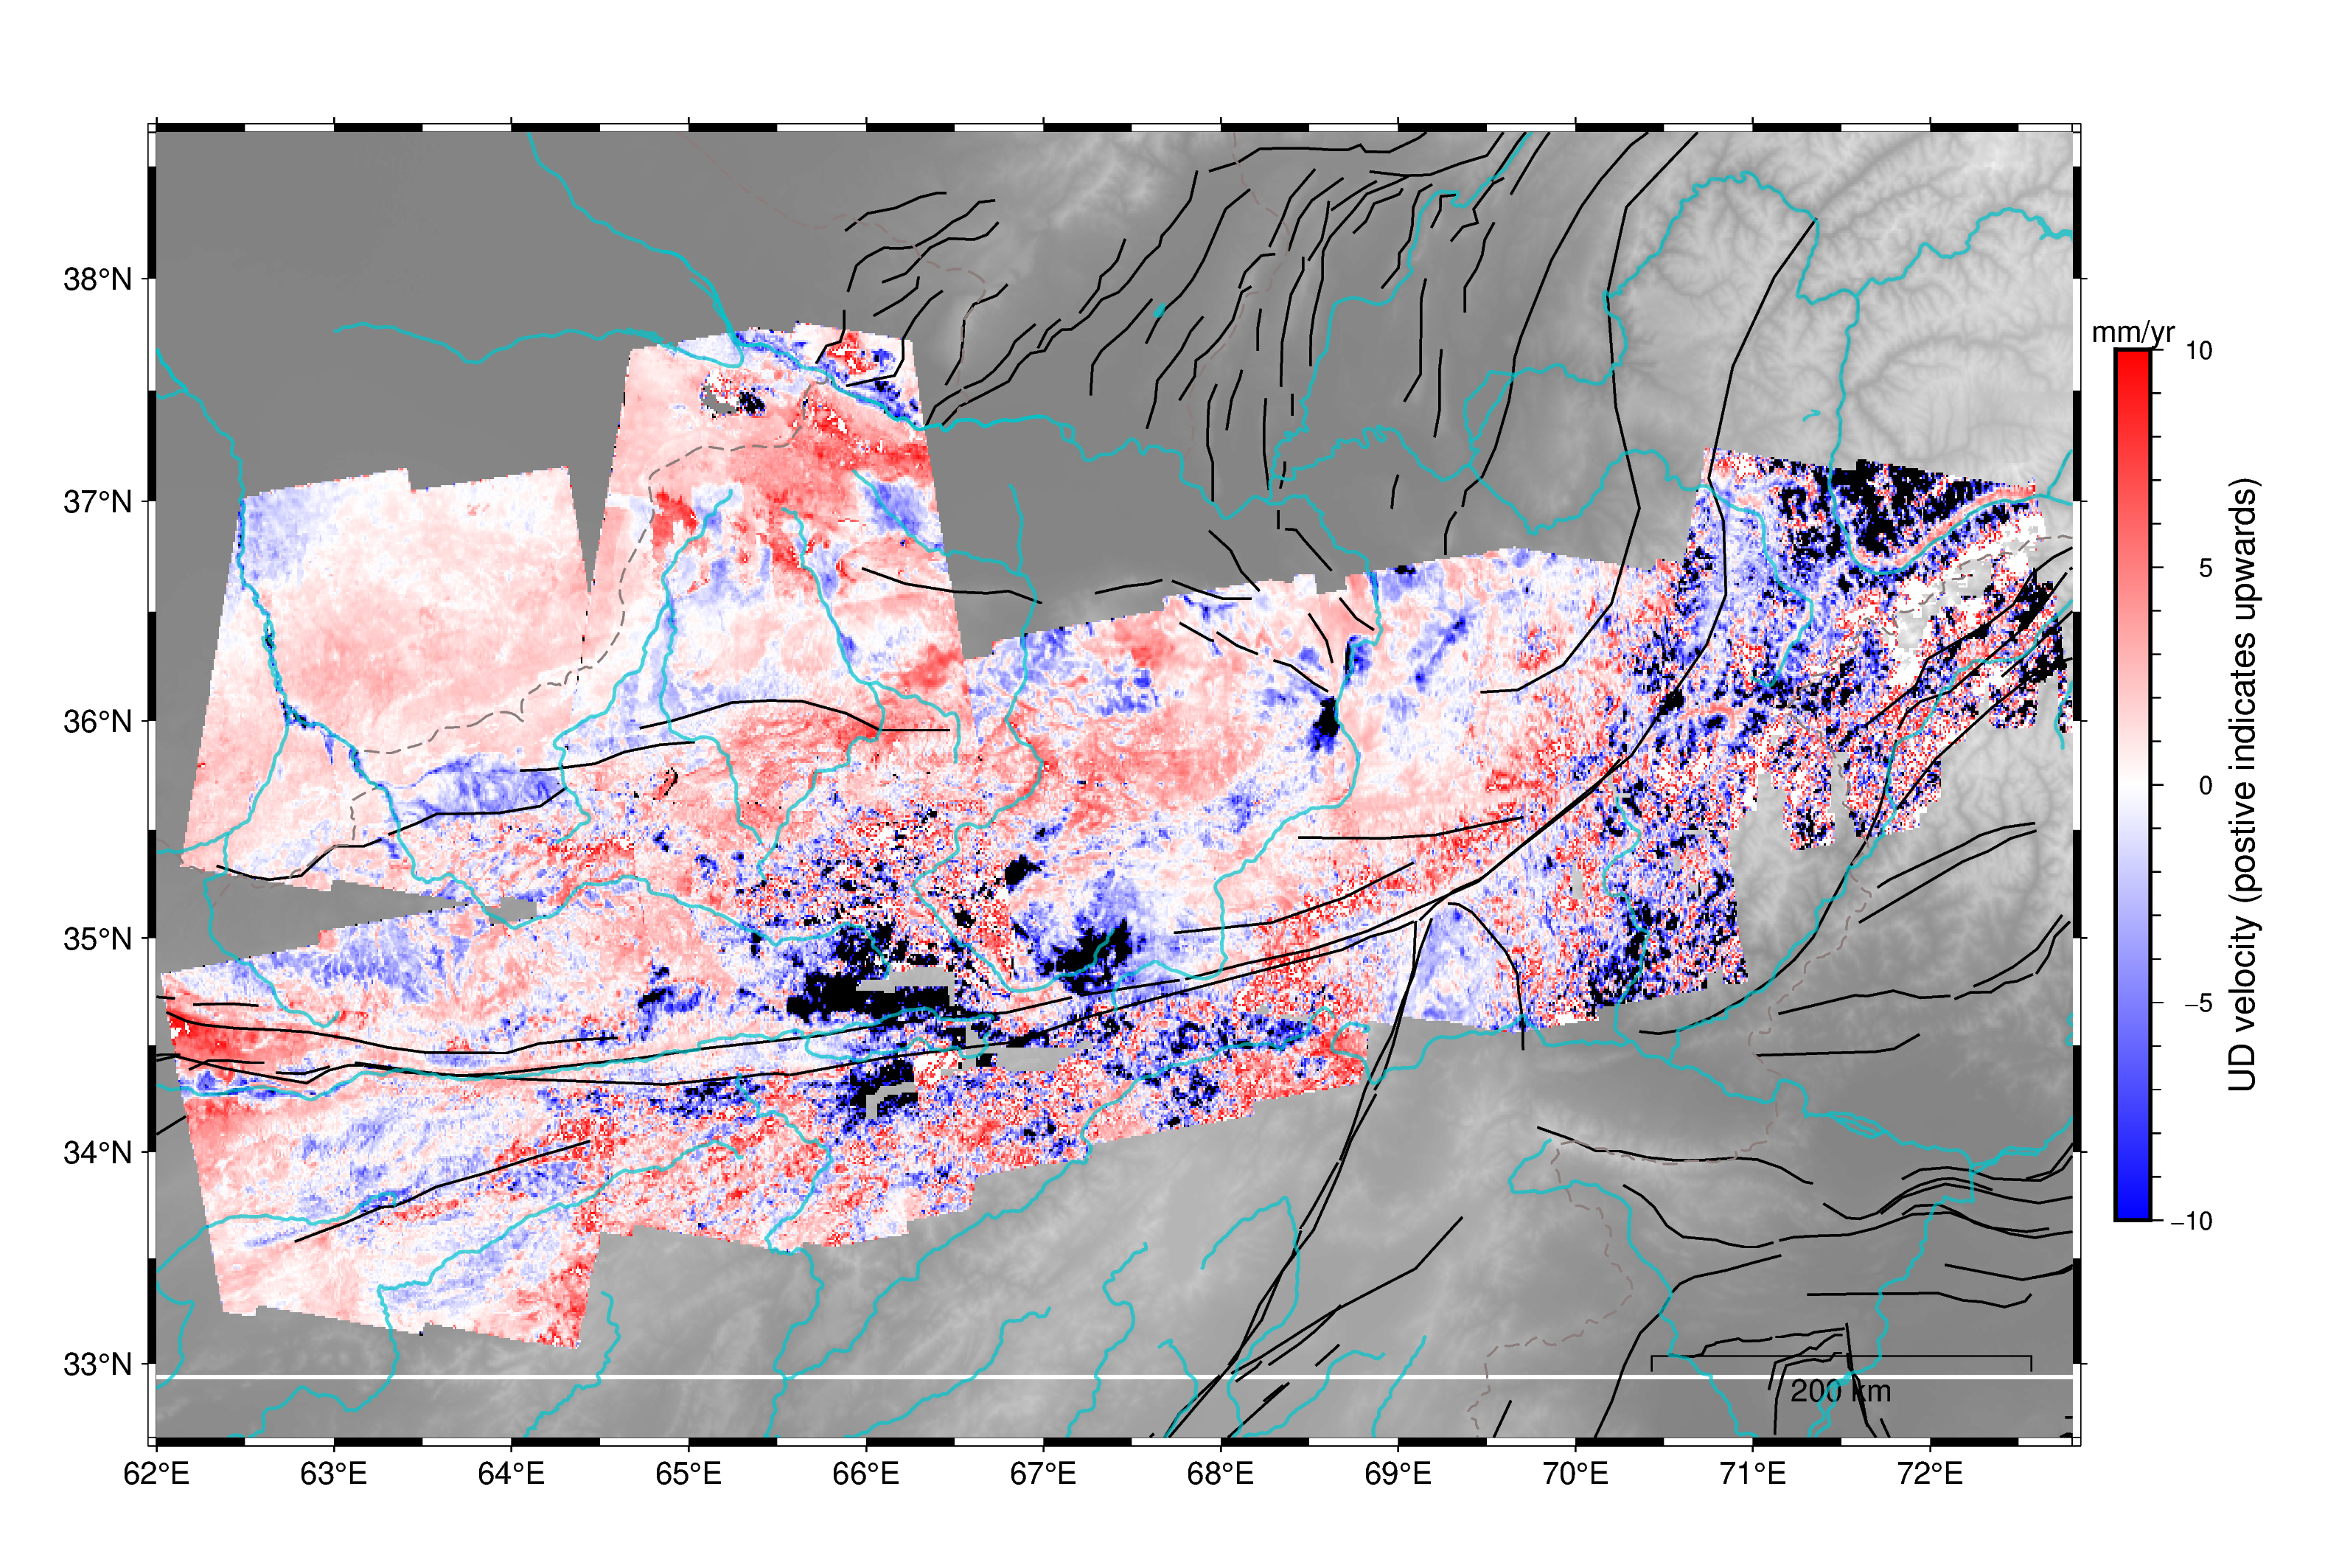

In [19]:
### GMT basemap ###
from pygmt.clib import Session
###########################################
## Specify coords
# llcrnrlat,llcrnrlon, urcrnrlat, urcrnrlon
# are the lat/lon values of the lower left and upper right corners of the map

llcrnrlon=62 # lower left corner longitude 
llcrnrlat=32.65 # lower left corner latitude
urcrnrlon=72.8 # upper right corner longitude
urcrnrlat=38.65 # upper right corner latitude


proj_scale_w = 22 # specify projection scale (width)
proj_scale_unit = "c" # choose between c (cm) and i (inches)
# 17.78c = 7i

x_y_shift = '3c'
# InSAR_tif =
# InSAR_NetCDF =

###########################################

centerlon = (urcrnrlon - llcrnrlon)/2 + llcrnrlon # midpoints
centerlat = (urcrnrlat - llcrnrlat)/2 + llcrnrlat
region=[llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat]

fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="fancy", FONT="Helvetica") # figure config (borders)

pygmt.config(MAP_FRAME_WIDTH="0.1c") 
# DONT do PS_MEDIA="A4" this somehow breaks the cyl equidistant resizing
# pygmt default unit doesn't change mapproject default (which runs on gmt)

fig.coast(region=[0, 26.7, 0, 18], projection="Q26.7c", frame=False, land="white")
# this should be A4
# Equidistant Cylindrical Projection (Plate Carrée)
# https://www.pygmt.org/latest/projections/cyl/cyl_equidistant.html

fig.shift_origin(xshift="1.8c", yshift="1.5c") # does NOT include border width
'''
xshift="3c"
yshift="3c"

args = ['-T', f'-X{xshift}', f'-Yh-{yshift}']
with Session() as lib:
        lib.call_module(module="plot", args=' '.join(args))
# does this make it such that it shifts from top right???

args = [f'{fin}', f'-R{region_str}', f'-J{projection}', '-I', '-V'] # get rid of -V later
with GMTTempFile() as fout:
ses.call_module(module="mapproject", args=' '.join(args)+ " ->" + fout.name)
'''

fig.coast(region=region,\
        projection="M%s/%s/%s%s" % (centerlon, centerlat, proj_scale_w, proj_scale_unit),\
        water="white", land="grey", shorelines="1/0.5p",\
        frame=["WSne", "a1f0.5"])

        # Mercator
        # a2f0.5 --> major ticks every 2 and minor ticks every 0.5

grid = pygmt.datasets.load_earth_relief("30s", registration="gridline", region=region)

fig.grdimage(grid=grid, cmap="bin/seabluelandgrey.cpt")
# fig.grdimage(grid=grid, cmap="geo")

#######################
## plotting UD
pygmt.makecpt(output="bin/polar_LOSdecomp", series=[-10, 10], cmap="bin/polar.cpt")
                    # redefine scale + inverse
                    # stored in local sesh
                                        
fig.grdimage(grid="bin/UD_mskd_gdalmerge2.tif"\
                , nan_transparent = True, transparency = 0, cmap="bin/polar_LOSdecomp")

#######################

## plotting faults
# https://www.pygmt.org/dev/gallery/lines/linefronts.html
fig.plot(data="bin/gem_active_faults.gmt", pen=f"0.7p,black") # gem

fig.coast(map_scale="g71.5/33+w200k", shorelines="1/0.5p", borders="1/0.6p, mistyrose4,-")
fig.coast(lakes="turquoise3", rivers="a/1p,turquoise3,4_solid", water="turquoise3", transparency=30) # want water above national borders


## legends and stuff

fig.colorbar(
    cmap="bin/polar_LOSdecomp", frame=["xa5f1+lUD velocity (postive indicates upwards)", "y+lmm/yr"],
    # offset (+o) by 0.5 cm horizontally and 0.8 cm vertically from anchor
    # point, and plotted horizontally (+h)
    position="JCR+o0.5/0c+w10c"
)

fig.show()
fig.savefig("frame_merge_map_UD_w22cm.png")

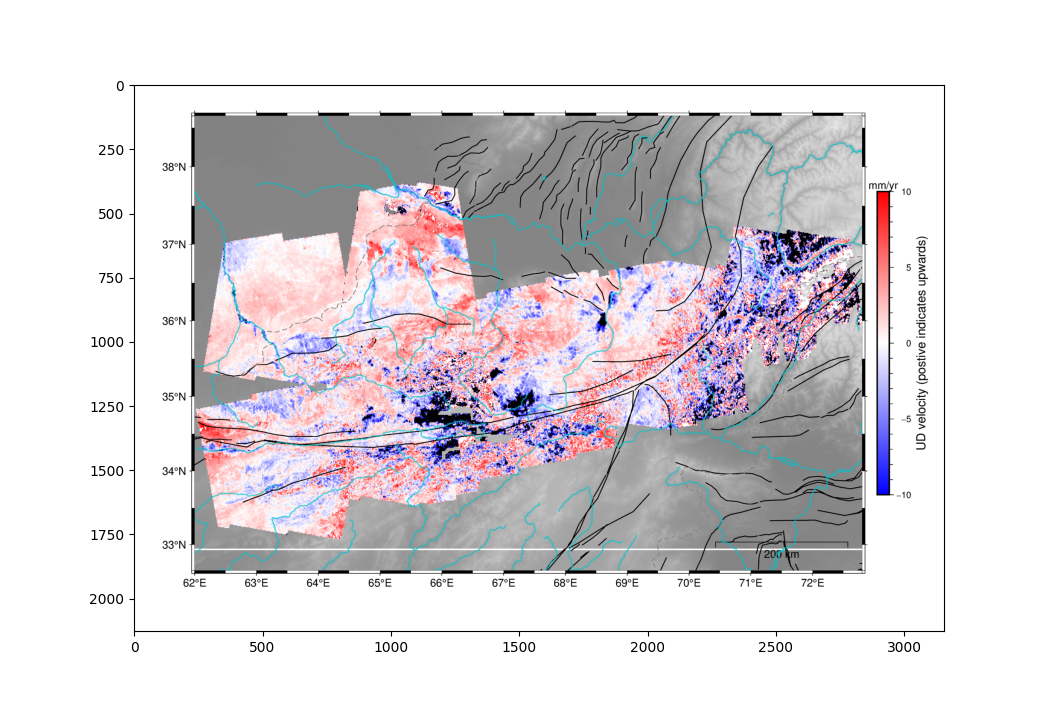

In [20]:
##### THIS WORKS #####

from pygmt.clib import Session
from pygmt.helpers import GMTTempFile


def interactive_pygmt_test(png_path, region, projection, xshift, yshift):
    '''
    Creates an interactive map from a borderless pyGMT png where you can click to retrieve coordinates.

    Parameters:
        png_path (str): path to the borderless pyGMT map

    '''

    ########## inputs ##########
    # turn pygmt region input into gmt str
    region_str = f"{region[0]}/{region[1]}/{region[2]}/{region[3]}"


    # unpact xshift yshift
    def unpack_xyshift(str):
      if str[-1].isalpha():
        shift_value = str[:-1]
        shift_unit = str[-1]

      return float(shift_value), shift_unit


    xshift_value, xshift_unit = unpack_xyshift(xshift)
    yshift_value, yshift_unit = unpack_xyshift(yshift)

    # we are working in cm
    if xshift_unit == "c":
      xshift_value = xshift_value
    elif xshift_unit == "i":
      xshift_value = xshift_value * 2.54
    elif xshift_unit == "p":
      xshift_value = (xshift_value * 72) * 2.54
    else:
      raise Exception("invalid xshift input (must be either c, i or p)") 
      
    # similarly for y
    if yshift_unit == "c":
      yshift_value = yshift_value
    elif yshift_unit == "i":
      yshift_value = yshift_value * 2.54
    elif yshift_unit == "p":
      yshift_value = (yshift_value * 72) * 2.54
    else:
      raise Exception("invalid yshift input (must be either c, i or p)") 
    
    # determine image dimension
    img = Image.open(png_path)
    width, height = img.size # canvas (width,height) tuple in pixels
    DPI_horz, DPI_vert = img.info.get('dpi')

    assert DPI_horz == DPI_vert # is this != even possible??

  
    # determine basemap dimension
    # width
    with Session() as ses:
       args = [f'-R{region_str}', f'-J{projection}', '-Ww', '-Di'] 
       # -D temporarily override PROJ_LENGTH_UNIT

       with GMTTempFile() as fout:
         ses.call_module(module="mapproject", args=' '.join(args)+ " ->" + fout.name)
         basemap_w = float(fout.read().strip())
      
    # height 
    # ! gmt mapproject -R66/78/34/41 -JM72.0/37.5/8i -Wh -V -Di
    with Session() as ses:
       args = [f'-R{region_str}', f'-J{projection}', '-Wh', '-Di'] 
       # -D temporarily override PROJ_LENGTH_UNIT

       with GMTTempFile() as fout:
         ses.call_module(module="mapproject", args=' '.join(args)+ " ->" + fout.name)
         basemap_h = float(fout.read().strip())

    
    ################################################
    ########## plots ##########
    fig = plt.figure(figsize=(width/DPI_horz, height/DPI_vert))
    ax1 = plt.subplot(111)

    '''
    code above doesnt "work' in the sense that its unnecessary
    as figure size != subplot axis size --> what to do with multiple subplots eg timeseries
    edit: subplot axis is currently set to image pixel size so ok now
    '''

    # plotting pygmt png image in bottom layer
    img = mpimg.imread(png_path)

    plt.imshow(img, origin='upper')
    # SOMEHOW MATPLOTLIB MIRRORS MY IMAGE WHEN I SET (0,0) AS BOTTOM LEFT (origin='lower')
    # i fix this later directly at pos_to_lonlat (by reversing input limit)

    
    def pos_to_lonlat(x, y, xshift_value, yshift_value):
      # xyshift input in inches
      x=(x/DPI_horz) * 2.54 # convert pixel to cm
      x = x - xshift_value

      y=(y/DPI_vert) * 2.54 # cm
      height_cm = (height/DPI_vert) * 2.54
      y = height_cm - y - yshift_value
      
      x=[x] # must be list w one value or np array
      y=[y]
      
      ### lon lat conversion using mapproject ###
      with Session() as ses:
        # with ses.virtualfile_in(data=data) as fin:
        with ses.virtualfile_from_vectors(x, y) as fin:
          args = [f'{fin}', f'-R{region_str}', f'-J{projection}', '-I', '-V'] # get rid of -V later
          with GMTTempFile() as fout:
            ses.call_module(module="mapproject", args=' '.join(args)+ " ->" + fout.name)
            out = fout.read().strip()

      lon, lat = [float(i) for i in out.split(' ')]
    
      return lon, lat


    pos = [] # in format [[None, None], [x, y], [x, y], ...]
    lonlat = []

    def onclick(event):
      pos.append([event.xdata, event.ydata])

      lon, lat = pos_to_lonlat(pos[-1][0], pos[-1][1],\
                               xshift_value, yshift_value)
      # pos[-1] represents last click (list with x, y)
      # this is x y input in pixels --> need to convert to in inches (gmt input)
      lonlat.append([lon, lat]) # converts x y to lon lat and appends

      ax1.set_title(f'Click {len(pos)}: {lon}, {lat}')

    
    cid=fig.canvas.mpl_connect('button_press_event', onclick)

    # plt.axis('off')
    plt.show()

    return

llcrnrlon=62 # lower left corner longitude 
llcrnrlat=32.65 # lower left corner latitude
urcrnrlon=72.8 # upper right corner longitude
urcrnrlat=38.65 # upper right corner latitude

centerlon = (urcrnrlon - llcrnrlon)/2 + llcrnrlon # midpoints
centerlat = (urcrnrlat - llcrnrlat)/2 + llcrnrlat
region=[llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat]
projection="M%s/%s/%s%s" % (centerlon, centerlat, proj_scale_w, proj_scale_unit)


%matplotlib widget
interactive_pygmt_test("frame_merge_map_UD_w22cmborder2cm.png", region, projection, "1.8c", "1.5c")

In [17]:
#### THIS WORKS DONT TOUCH THIS ####
#### THIS IS IN CM NOT INCHES ####

from pygmt.clib import Session
from pygmt.helpers import GMTTempFile

llcrnrlon=62 # lower left corner longitude 
llcrnrlat=32.65 # lower left corner latitude
urcrnrlon=72.8 # upper right corner longitude
urcrnrlat=38.65 # upper right corner latitude

centerlon = (urcrnrlon - llcrnrlon)/2 + llcrnrlon # midpoints
centerlat = (urcrnrlat - llcrnrlat)/2 + llcrnrlat
region=[llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat]
projection="M%s/%s/%s%s" % (centerlon, centerlat, proj_scale_w, proj_scale_unit)

png_path = "frame_merge_map_UD_A4w22cmborder3cm.png"
img = Image.open(png_path)
width, height = img.size # canvas (width,height) tuple in pixels
DPI_horz, DPI_vert = img.info.get('dpi')

###############
region_str = f"{region[0]}/{region[1]}/{region[2]}/{region[3]}"

# ! gmt mapproject -R66/78/34/41 -JM72.0/37.5/8i -Wh -V -Di

with Session() as ses:
    # args = [f'-R{region_str}', f'-J{projection}', '-Wh', '-Di'] 
    args = [f'-R{region_str}', f'-J{projection}', '-Wh'] 
    # -D temporarily override PROJ_LENGTH_UNIT

    with GMTTempFile() as fout:
      ses.call_module(module="mapproject", args=' '.join(args)+ " ->" + fout.name)
      basemap_h = float(fout.read().strip())

'''
print("this")
width_cm = width/DPI_horz
height_cm = height/DPI_vert
print(width_cm, height_cm) # 3508 2481
'''
x=2950 # pixels
xshift_value = 3 # cm
y=350
yshift_value = 3

x=(x/DPI_horz) * 2.54 # convert pixel to cm
x = x - xshift_value

y=(y/DPI_vert) * 2.54 # cm
height_cm = (height/DPI_vert) * 2.54
y = height_cm - y - yshift_value
# y = height_cm -y

'''
x=350 # pixels
xshift_value = 3 / 2.54 # cm to inches
y=2100
yshift_value = 3 / 2.54

x=(x/DPI_horz) # convert pixel to inches
x = x + xshift_value

y=(y/DPI_vert) # inches
y = (height/DPI_vert)-y
'''
x=[x] # must be list w one value or np array
y=[y]
with Session() as ses:
  # with ses.virtualfile_in(data=data) as fin:
  with ses.virtualfile_from_vectors(x, y) as fin:
    args = [f'{fin}', f'-R{region_str}', f'-J{projection}', '-I', '-V'] # get rid of -V later , '-Di'
    with GMTTempFile() as fout:
      ses.call_module(module="mapproject", args=' '.join(args)+ " ->" + fout.name)
      out = fout.read().strip()
      lon, lat = [float(i) for i in out.split(' ')]

print("lon, lat", (lon, lat))

'''
with Session() as ses:
       args = [f'-R{region_str}', f'-J{projection}', '-Wh', '-Di'] 
       # -D temporarily override PROJ_LENGTH_UNIT

       with GMTTempFile() as fout:
         ses.call_module(module="mapproject", args=' '.join(args)+ " ->" + fout.name)
         basemap_height = float(fout.read().strip())

print("this")
print(basemap_height)
'''

mapproject [INFORMATION]: Processing input table data
mapproject [INFORMATION]: Transform 62/72.8/32.65/38.65 <- 0/22/0/14.9883843023 [cm]
mapproject [INFORMATION]: Reading Data Table from Input memory location via vector
mapproject [INFORMATION]: Writing Data Table to file /var/folders/xp/d0lbwvf108l78qt1c6tlwylh0000gn/T/pygmt-tvj813xp.txt
mapproject [INFORMATION]: Projected 1 points
mapproject [INFORMATION]: Input extreme values:  Xmin: 21.9767166201 Xmax: 21.9767166201 Ymin: 15.0425027517 Ymax 15.0425027517
mapproject [INFORMATION]: Output extreme values: Xmin: 72.7885699771 Xmax: 72.7885699771 Ymin: 38.6708306026 Ymax 38.6708306026
mapproject [INFORMATION]: Mapped 1 x-y pairs [cm] to lon-lat pairs


lon, lat (72.7885699771, 38.6708306026)


'\nwith Session() as ses:\n       args = [f\'-R{region_str}\', f\'-J{projection}\', \'-Wh\', \'-Di\'] \n       # -D temporarily override PROJ_LENGTH_UNIT\n\n       with GMTTempFile() as fout:\n         ses.call_module(module="mapproject", args=\' \'.join(args)+ " ->" + fout.name)\n         basemap_height = float(fout.read().strip())\n\nprint("this")\nprint(basemap_height)\n'

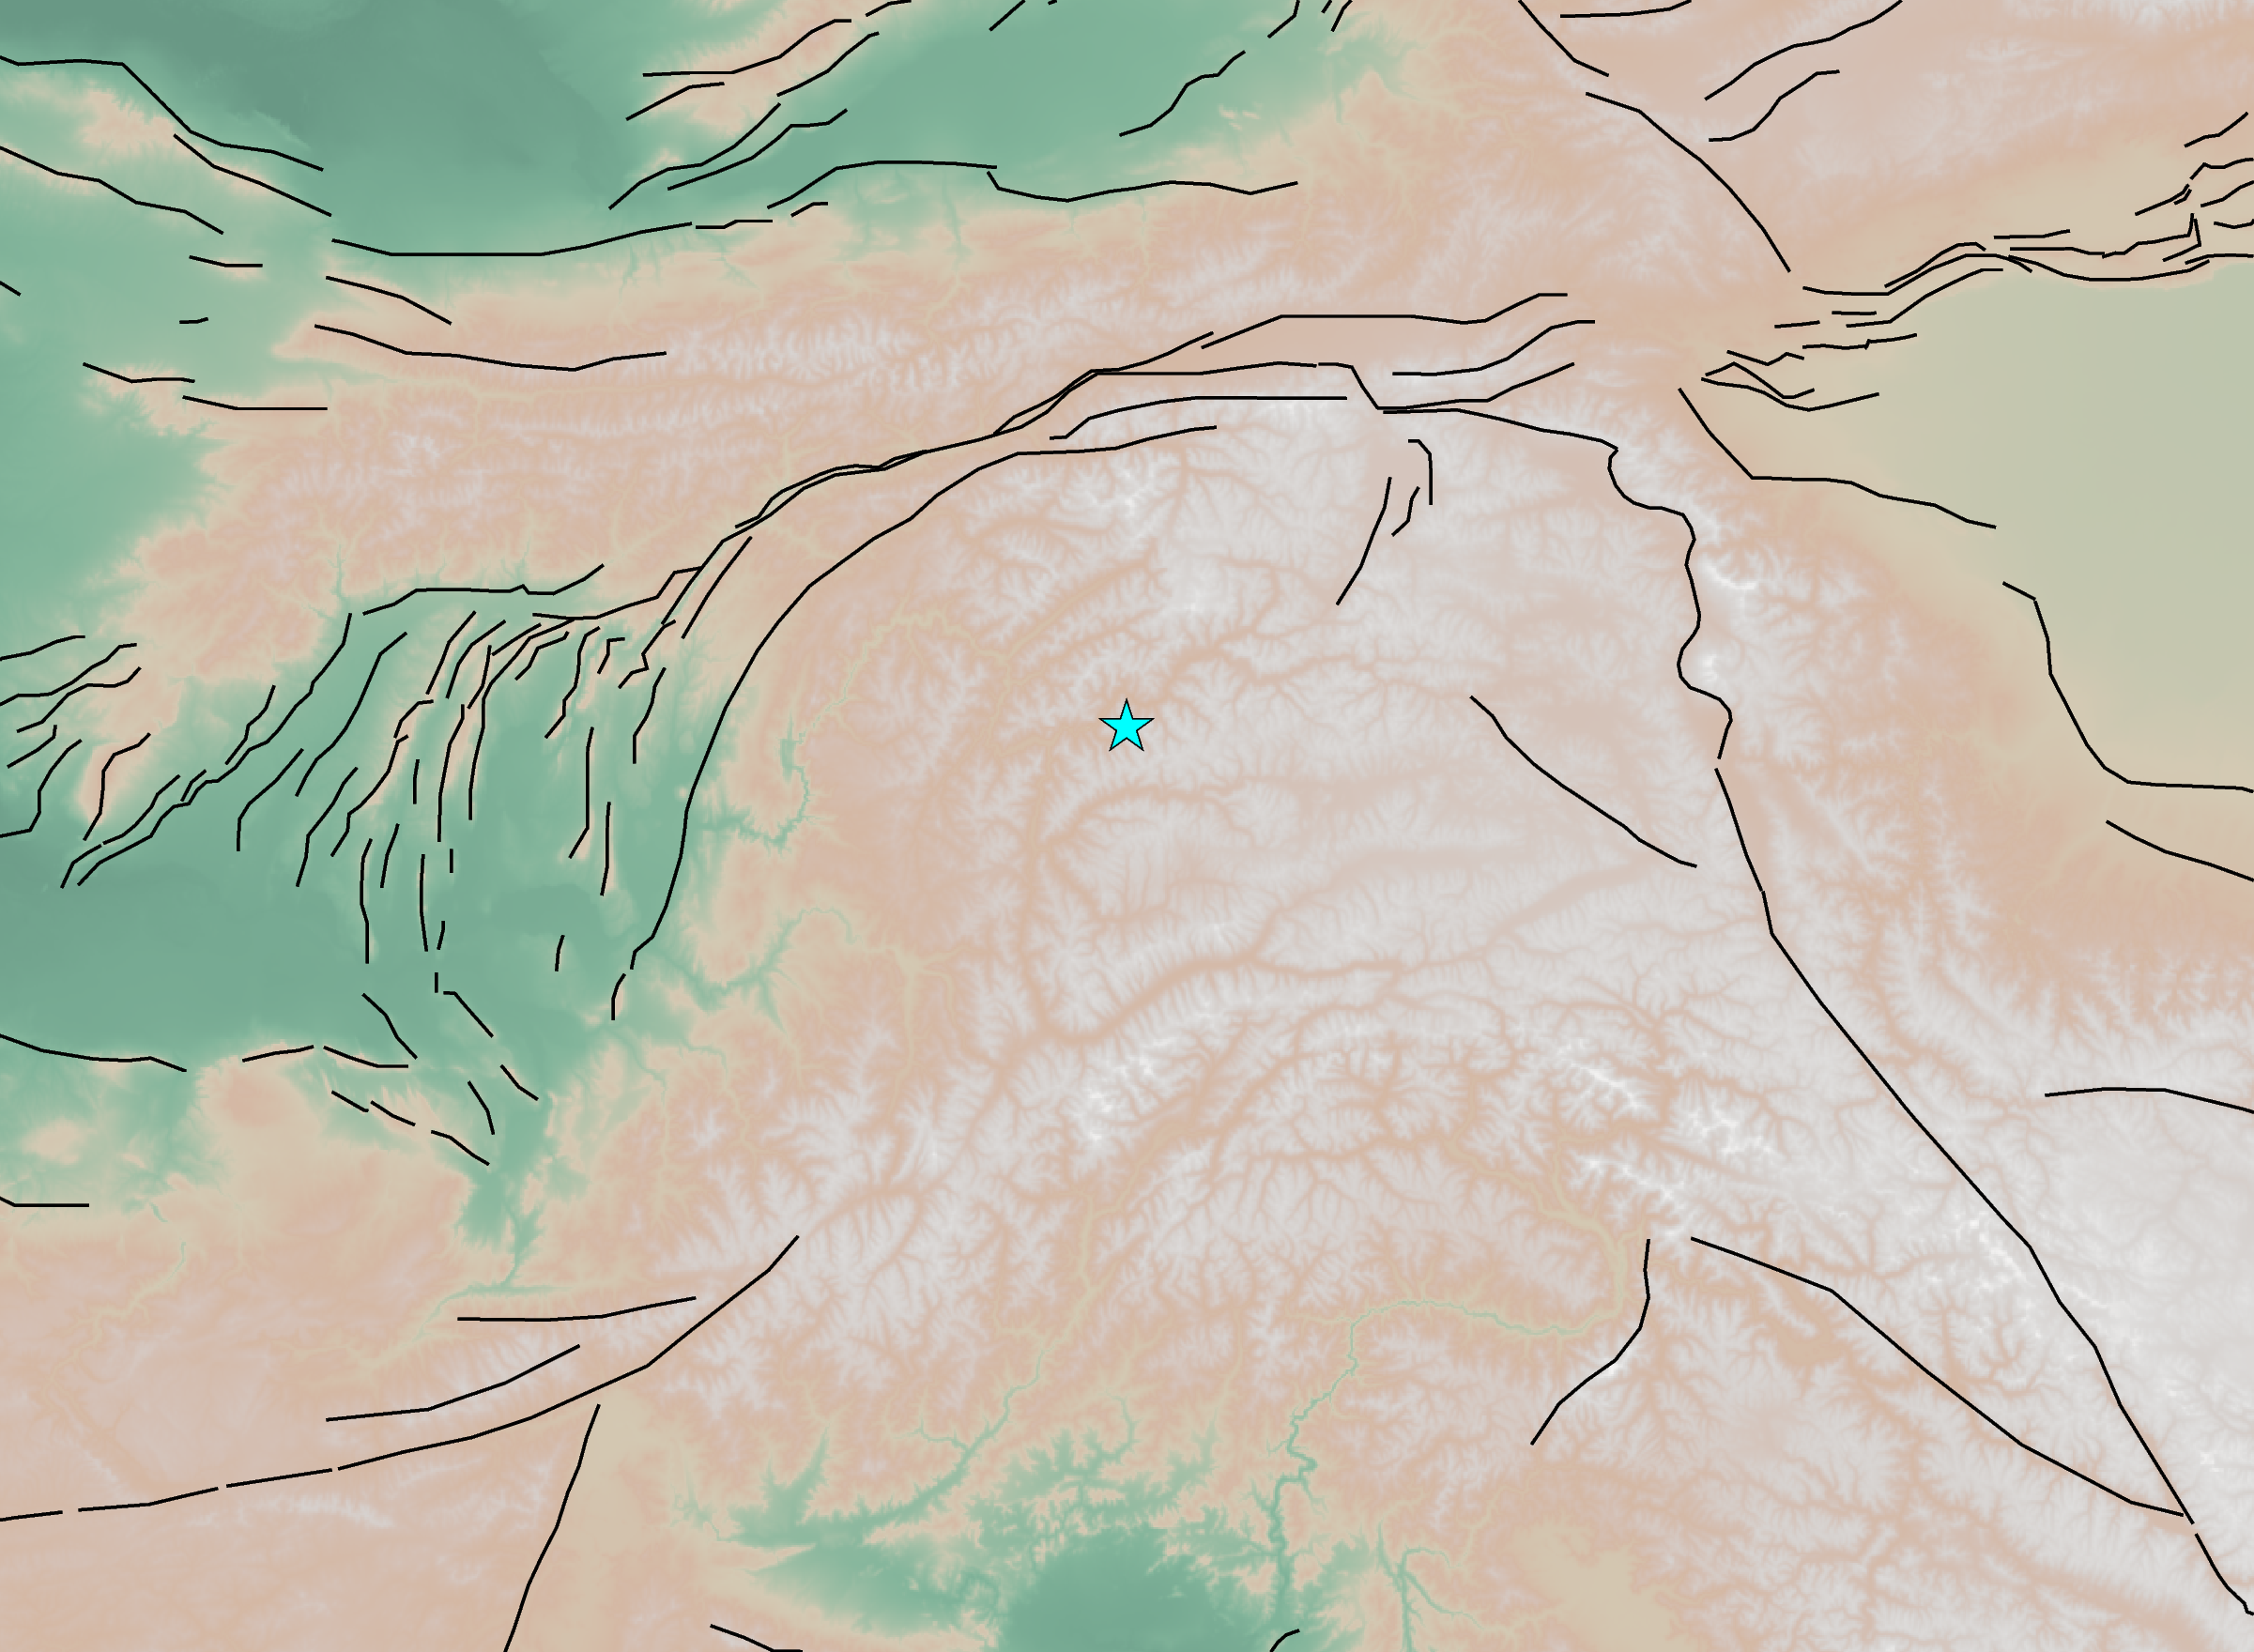

In [37]:
# basic test w mapproject first

import pygmt

### Making a demo pyGMT basemap ###

###########################################
## Specify coords
# llcrnrlat,llcrnrlon, urcrnrlat, urcrnrlon
# are the lat/lon values of the lower left and upper right corners of the map

llcrnrlon=66 # lower left corner longitude 
llcrnrlat=34 # lower left corner latitude
urcrnrlon=78 # upper right corner longitude
urcrnrlat=41 # upper right corner latitude


proj_scale_w = 8 # specify projection scale (width)
proj_scale_unit = "i" # choose between c (cm) and i (inches)
# 17.78c = 7i
###########################################

centerlon = (urcrnrlon - llcrnrlon)/2 + llcrnrlon # midpoints
centerlat = (urcrnrlat - llcrnrlat)/2 + llcrnrlat
region=[llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat]

grid = pygmt.datasets.load_earth_relief("30s", registration="gridline", region=region)


fig = pygmt.Figure()

# pygmt.config(MAP_FRAME_TYPE="plain") # figure config (borders)
fig.coast(region=region,\
          projection="M%s/%s/%s%s" % (centerlon, centerlat, proj_scale_w, proj_scale_unit),\
          water="white", land="grey", shorelines="1/0.5p")

          # Mercator
          # a2f0.5 --> major ticks every 2 and minor ticks every 0.5

fig.grdimage(grid=grid, cmap="elevation")


## plotting faults
# https://www.pygmt.org/dev/gallery/lines/linefronts.html
fig.plot(data="bin/HimaTibetMap.gmt", pen=f"0.7p,black") # all faults
fig.plot(x=72, y=38, style="a0.5c", pen="thinnest", fill="cyan")

fig.show()
fig.savefig("test2.png")

In [196]:
print(region)
projection="M%s/%s/%s%s" % (centerlon, centerlat, proj_scale_w, proj_scale_unit)
print(projection)

[66, 78, 34, 41]
M72.0/37.5/8i


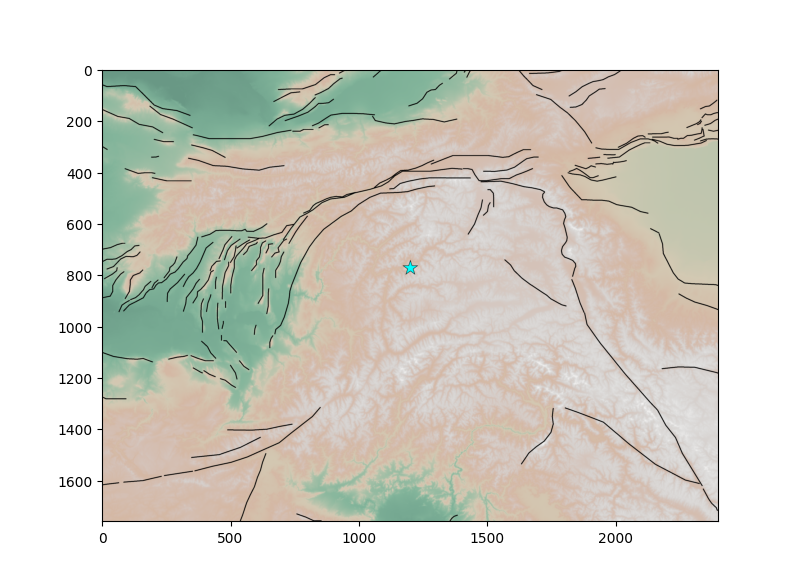

In [38]:
## OLD TEST

from pygmt.clib import Session
from pygmt.helpers import GMTTempFile

import subprocess


def interactive_pygmt_test(png_path, llcrnrlat, urcrnrlat, llcrnrlon, urcrnrlon):
    '''
    Creates an interactive map from a borderless pyGMT png where you can click to retrieve coordinates.

    Parameters:
        png_path (str): path to the borderless pyGMT map
        llcrnrlon (float): lower left corner longitude
        llcrnrlat (float): lower left corner latitude
        urcrnrlon (float): upper right corner longitude
        urcrnrlat (float): upper right corner latitude
        grid_freq (float): grid frequency (degrees)

    '''

    # determine image dimension
    img = Image.open(png_path)
    width, height = img.size # (width,height) tuple in pixels
    DPI_horz, DPI_vert = img.info.get('dpi')

    assert DPI_horz == DPI_vert # is this != even possible??

    fig = plt.figure(figsize=(width/DPI_horz, height/DPI_vert))
    ax1 = plt.subplot(111)
  

    '''
    code above doesnt "work' in the sense that its unnecessary
    as figure size != subplot axis size --> what to do with multiple subplots eg timeseries
    edit: subplot axis is currently set to image pixel size so ok now
    '''
    
    # plotting pygmt png image in bottom layer
    img = mpimg.imread(png_path)
    plt.imshow(img, origin='upper')
    # SOMEHOW MATPLOTLIB MIRRORS MY IMAGE WHEN I SET (0,0) AS BOTTOM LEFT (origin='lower')
    # i fix this later directly at pos_to_lonlat (by reversing input limit)


    ################
    # mapproject test w Mercator
    llcrnrlon=66 # lower left corner longitude 
    llcrnrlat=34 # lower left corner latitude
    urcrnrlon=78 # upper right corner longitude
    urcrnrlat=41 # upper right corner latitude

    centerlon = (urcrnrlon - llcrnrlon)/2 + llcrnrlon # midpoints
    centerlat = (urcrnrlat - llcrnrlat)/2 + llcrnrlat
    region=[llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat]
    projection="M%s/%s/%s%s" % (centerlon, centerlat, 8, "i")

    
    def pos_to_lonlat(x, y, xshift=0, yshift=0):
      y = height-y
      x=(x/DPI_horz) * 2.54 # in cm (mapproject takes in map scale in cm)
      y=(y/DPI_vert) * 2.54
      x=[x] # must be list w one value or np array
      y=[y] # in map scale cm

      region_str = f"{llcrnrlon}/{urcrnrlon}/{llcrnrlat}/{urcrnrlat}"
      
      with Session() as ses:
        #with ses.virtualfile_in(data=data) as fin:
        with ses.virtualfile_from_vectors(x, y) as fin:
          region_str = f"{llcrnrlon}/{urcrnrlon}/{llcrnrlat}/{urcrnrlat}"
          args = [f'{fin}', f'-R{region_str}', f'-J{projection}', '-I', '-V'] # get rid of -V later
          with GMTTempFile() as fout:
            ses.call_module(module="mapproject", args=' '.join(args)+ " ->" + fout.name)
            out = fout.read().strip()

      lon, lat = [float(i) for i in out.split(' ')]
    
      return lon, lat

    pos = [] # in format [[None, None], [x, y], [x, y], ...]
    lonlat = []



    def onclick(event):
      pos.append([event.xdata, event.ydata])

      lon, lat = pos_to_lonlat(pos[-1][0], pos[-1][1]) # pos[-1] represents last click (list with x, y)
      # this is x y input in pixels --> need to convert to in inches (gmt input)
      lonlat.append([lon, lat]) # converts x y to lon lat and appends

      ax1.set_title(f'Click {len(pos)}: {lon}, {lat}')

    
    cid=fig.canvas.mpl_connect('button_press_event', onclick)

    plt.show()

    return

%matplotlib widget
interactive_pygmt_test("test2.png", llcrnrlat, urcrnrlat, llcrnrlon, urcrnrlon)

In [9]:
# THIS WORKS DONT TOUCH IT
img = Image.open("test2.png")
width, height = img.size # (width,height) tuple in pixels
DPI_horz, DPI_vert = img.info.get('dpi')

assert DPI_horz == DPI_vert

x=1200
y=765
y = height-y
x=(x/DPI_horz) * 2.54 # in cm (mapproject takes in map scale in cm)
y=(y/DPI_vert) * 2.54
x=[x] # must be list w one value or np array
y=[y] # in map scale cm
projection="M%s/%s/%s%s" % (centerlon, centerlat, width/DPI_horz, "i")

llcrnrlon=66 # lower left corner longitude 
llcrnrlat=34 # lower left corner latitude
urcrnrlon=78 # upper right corner longitude
urcrnrlat=41 # upper right corner latitude
region_str = f"{llcrnrlon}/{urcrnrlon}/{llcrnrlat}/{urcrnrlat}"
#####################
with Session() as ses:
        #with ses.virtualfile_in(data=data) as fin:
        with ses.virtualfile_from_vectors(x, y) as fin:
          region_str = f"{llcrnrlon}/{urcrnrlon}/{llcrnrlat}/{urcrnrlat}"
          args = [f'{fin}', f'-R{region_str}', f'-J{projection}', '-I', '-V'] # get rid of -V later
          with GMTTempFile() as fout:
            ses.call_module(module="mapproject", args=' '.join(args)+ " ->" + fout.name)
            out = fout.read().strip()
lon, lat = [float(i) for i in out.split(' ')]
print(lon, lat)
            #print(fout.read().strip())
            # format: lon\nlat
          
'''
          # send output to file so that we can read it
          with GMTTempFile() as fout:
            ses.call_module("info", fin + " ->" + fout.name)
            # this returns fout.name as a tempfile i think
            # format: lon\nlat ??
            # "fout.read().strip()" returns empty list [] for some reason
            print("this")
            print(fout.read().strip())
            # lon, lat = float(fout_content[0]), float(fout_content[1])
'''

print(args)

'''
      with Session() as lib:
        with lib.virtualfile_in(
          x=x, y=y
        ) as vintbl:
          lib.call_module(module="mapproject", args=build_arg_list(kwargs, infile=vintbl))

      args = [f'{vingrd}', '-T', '-BNSEW', '-Ba.1f.05', '-C']
      s.call_module('grdview', args=' '.join(args))

      https://forum.generic-mapping-tools.org/t/replicate-grdview-t-with-pygmt/5121

      with pygmt.clib.Session() as s:
        with s.virtualfile_in(check_kind="raster", data=grd) as vingrd:
          args = [f'{vingrd}', '-T', '-BNSEW', '-Ba.1f.05', '-C']
          s.call_module('grdview', args=' '.join(args))

      lon, lat = mapproject(region=region, projection="M%s/%s/%s%s" % (centerlon, centerlat, width/DPI_horz, "i"),\
            I=True, x=x, y=y)
      '''


mapproject [INFORMATION]: Processing input table data
mapproject [INFORMATION]: Transform 66/78/34/41 <- 0/20.3285073237/0/14.9042528857 [cm]
mapproject [INFORMATION]: Reading Data Table from Input memory location via vector
mapproject [INFORMATION]: Writing Data Table to file /var/folders/xp/d0lbwvf108l78qt1c6tlwylh0000gn/T/pygmt-mm8blgi3.txt
mapproject [INFORMATION]: Projected 1 points
mapproject [INFORMATION]: Input extreme values:  Xmin: 10.16002032 Xmax: 10.16002032 Ymin: 8.42435018203 Ymax 8.42435018203
mapproject [INFORMATION]: Output extreme values: Xmin: 71.9975010412 Xmax: 71.9975010412 Ymin: 38.0382098194 Ymax 38.0382098194
mapproject [INFORMATION]: Mapped 1 x-y pairs [cm] to lon-lat pairs


71.9975010412 38.0382098194
['@GMTAPI@-S-I-D-V-T-N-000000', '-R66/78/34/41', '-JM72.0/37.5/8.003349340032013i', '-I', '-V']


In [337]:
testout.split('\n') #.strip()
# already a list

['66 34']

In [14]:
# ! gmt mapproject -R66/78/34/41 -JM72.0/37.5/8i -Wh -V -Di 
# ! gmt mapproject -R66/78/34/41 -JM72.0/37.5/8i -We -V -Di
region=[-136, -118.5, 38.5, 53.1]
region_str = f"{region[0]}/{region[1]}/{region[2]}/{region[3]}"
projection="B-127.25/45.8/43.19/47.86/11c"
print(region_str)
! gmt mapproject -R-136/-118.5/38.5/53.1 -JB-127.25/45.8/43.19/47.86/11c -Wm -V -Di

-136/-118.5/38.5/53.1
mapproject [INFORMATION]: Processing input table data
mapproject [INFORMATION]: Using spherical projection with conformal latitudes
mapproject [INFORMATION]: Writing Data Table to Standard Output stream
-136	-118.5	0	4.67179308424


In [76]:
print(width)
print(height)
print(width/DPI_horz)

2401
1760
8.003349340032013


In [299]:
# 5401 3960
x=5401
y=1
'''
x=1
y=1559
'''


y = height - y
x= x / DPI_horz # convert to inches
y= y / DPI_vert
data = np.array([x,y])
print(data)
# input data x y into echo
! echo 0 0 | gmt mapproject -R66/78/34/41 -JM72.0/37.5/8i -I -Fi -V

[18.00336934  5.86334506]


UnboundLocalError: cannot access local variable 'child' where it is not associated with a value

In [358]:
! echo 10.32 0 | gmt mapproject -R66/78/34/41 -JM72.0/37.5/8i -I -V

mapproject [INFORMATION]: Processing input table data
mapproject [INFORMATION]: Transform 66/78/34/41 <- 0/20.32/0/14.8980155707 [cm]
mapproject [INFORMATION]: Reading Data Table from Standard Input stream
mapproject [INFORMATION]: Writing Data Table to Standard Output stream
72.094488189	34
mapproject [INFORMATION]: Projected 1 points
mapproject [INFORMATION]: Input extreme values:  Xmin: 10.32 Xmax: 10.32 Ymin: 0 Ymax 0
mapproject [INFORMATION]: Output extreme values: Xmin: 72.094488189 Xmax: 72.094488189 Ymin: 34 Ymax 34
mapproject [INFORMATION]: Mapped 1 x-y pairs [cm] to lon-lat pairs


In [313]:
import io, os, subprocess
with io.StringIO() as tempout:
    cmd = "echo 78 41 " #| gmt mapproject -R66/78/34/41 -JM72.0/37.5/8i -Fi"
    os.system(cmd)
    #cmd = ['echo','78','41']
    #subprocess.check_call(cmd, stdout=tempout)
    capture = tempout.getvalue()

print('this is')
print(capture)

78 41
this is



In [310]:
help(os.system)


Help on built-in function system in module posix:

system(command)
    Execute the command in a subshell.



In [ ]:
from pygmt.helpers import GMTTempFile

import numpy as np

import pandas as pd

x = [1, 2, 3]

y = np.array([4, 5, 6])

z = pd.Series([7, 8, 9])

with Session() as ses:

    with ses.virtualfile_from_vectors(x, y, z) as fin:

        # Send the output to a file so that we can read it

        with GMTTempFile() as fout:

            ses.call_module("info", f"{fin} ->{fout.name}")

            print(fout.read().strip())

In [294]:
41775800.3829/30628765.9735

1.3639400431295343

In [282]:
! echo 41775800.3829 0 | gmt mapproject -R66/78/34/41 -JM72.0/37.5/8i -I -Fi -V

mapproject [INFORMATION]: Processing input table data
mapproject [INFORMATION]: Transform 66/78/34/41 <- 0/41775800.3829/0/30628765.9735 [inch]
mapproject [INFORMATION]: Reading Data Table from Standard Input stream
mapproject [INFORMATION]: Writing Data Table to Standard Output stream
78	34
mapproject [INFORMATION]: Projected 1 points
mapproject [INFORMATION]: Input extreme values:  Xmin: 41775800.3829 Xmax: 41775800.3829 Ymin: 0 Ymax 0
mapproject [INFORMATION]: Output extreme values: Xmin: 78 Xmax: 78 Ymin: 34 Ymax 34
mapproject [INFORMATION]: Mapped 1 x-y pairs [inch] to lon-lat pairs


In [289]:
41775800.3829/(width*300)

57.997779234902126

In [270]:
! echo 0 0 | gmt mapproject -R66/78/34/41 -JM72.0/37.5/8i -I -V -Fi
# -fp

mapproject [INFORMATION]: Processing input table data
mapproject [INFORMATION]: Transform 66/78/34/41 <- 0/41775800.3829/0/30628765.9735 [inch]
mapproject [INFORMATION]: Reading Data Table from Standard Input stream
mapproject [INFORMATION]: Writing Data Table to Standard Output stream
66	34
mapproject [INFORMATION]: Projected 1 points
mapproject [INFORMATION]: Input extreme values:  Xmin: 0 Xmax: 0 Ymin: 0 Ymax 0
mapproject [INFORMATION]: Output extreme values: Xmin: 66 Xmax: 66 Ymin: 34 Ymax 34
mapproject [INFORMATION]: Mapped 1 x-y pairs [inch] to lon-lat pairs


In [220]:
'''
To transform a remote file with (latitude,longitude) into (x, y) positions in cm on a Mercator grid 
for a given scale of 0.5 cm per degree and selected region, run:
'''

! echo 0 0 | gmt mapproject -R-180/180/-72/72 -Jm0.5c -:

52.6075639182	90


In [200]:

'''
[66, 78, 34, 41]
M72.0/37.5/8i
'''
! echo 0 0 | gmt mapproject -R66/78/34/41 -JM72.0/37.5/8i -I

66	34


In [192]:
img = mpimg.imread("test2.png")
width, height = img.size
print(width, height)
print(width/DPI_horz)

TypeError: cannot unpack non-iterable int object

In [18]:
from pygmt.clib import Session

help(Session.virtualfile_in)


Help on function virtualfile_in in module pygmt.clib.session:

virtualfile_in(self, check_kind=None, data=None, x=None, y=None, z=None, extra_arrays=None, required_z=False, required_data=True)
    Store any data inside a virtual file.

    This convenience function automatically detects the kind of data passed
    into it, and produces a virtualfile that can be passed into GMT later
    on.

    Parameters
    ----------
    check_kind : str or None
        Used to validate the type of data that can be passed in. Choose
        from 'raster', 'vector', or None. Default is None (no validation).
    data : str or pathlib.Path or xarray.DataArray or numpy.ndarray, pandas.DataFrame, xarray.Dataset, or geopandas.GeoDataFrame or None
        Any raster or vector data format. This could be a file name or
        path, a raster grid, a vector matrix/arrays, or other supported
        data input.
    x/y/z : 1-D arrays or None
        x, y, and z columns as numpy arrays.
    extra_arrays : list

In [35]:
help(Image)

Help on module PIL.Image in PIL:

NAME
    PIL.Image

DESCRIPTION
    # The Python Imaging Library.
    # $Id$
    #
    # the Image class wrapper
    #
    # partial release history:
    # 1995-09-09 fl   Created
    # 1996-03-11 fl   PIL release 0.0 (proof of concept)
    # 1996-04-30 fl   PIL release 0.1b1
    # 1999-07-28 fl   PIL release 1.0 final
    # 2000-06-07 fl   PIL release 1.1
    # 2000-10-20 fl   PIL release 1.1.1
    # 2001-05-07 fl   PIL release 1.1.2
    # 2002-03-15 fl   PIL release 1.1.3
    # 2003-05-10 fl   PIL release 1.1.4
    # 2005-03-28 fl   PIL release 1.1.5
    # 2006-12-02 fl   PIL release 1.1.6
    # 2009-11-15 fl   PIL release 1.1.7
    #
    # Copyright (c) 1997-2009 by Secret Labs AB.  All rights reserved.
    # Copyright (c) 1995-2009 by Fredrik Lundh.
    #
    # See the README file for information on usage and redistribution.
    #

CLASSES
    builtins.Exception(builtins.BaseException)
        DecompressionBombError
    builtins.RuntimeWarning(buil

In [ ]:
fig = pygmt.Figure()

fig.coast(region=region,\
        projection="M%s/%s/%s%s" % (centerlon, urcrnrlat, proj_scale_w + 2, proj_scale_unit),\
        land="white")

fig.show()

In [15]:
! echo 20 40 | gmt mapproject -R-180/180/-72/72 -Jm0.5c


62.7514463282	110


In [31]:
import subprocess as subp
cmd = "echo 20 40 | gmt mapproject -R-180/180/-72/72 -Jm0.5c"
#help(subp.check_output) #(cmd)
cmd = ["gmt", "mapproject", "-R-180/180/-72/72", "-Jm0.5c"]
#cmd = ["echo","20"]

out = subp.check_output(cmd, input=b"echo 20 40")
out


b''

In [30]:
out.decode()

'20\n'

In [ ]:
! ls /opt/anaconda3/envs/pygmt/lib/python3.12/site-packages/IntPyGMT

IntPyGMT_overlay.py __init__.py         __pycache__         mapproject.py
